##  Airbnb New User Booking Prediction
## Data Preprocessing - feature engineering - modeling  

## Objective
Clean and prepare the data for modeling by handling missing values, encoding categorical variables, normalizing features, extracting date features, and modeling using xgboost 

## Import Required Libraries

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import ndcg_score
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import OrdinalEncoder

## Load Datasets


In [38]:
# Define file paths
train_path = r'C:\Users\Family\Desktop\airbnb-recruiting-new-user-bookings\train_users_2.csv.zip'
test_path = r'C:\Users\Family\Desktop\airbnb-recruiting-new-user-bookings\test_users.csv.zip'
sessions_path = r'C:\Users\Family\Desktop\airbnb-recruiting-new-user-bookings\sessions.csv.zip'

# Load train data
train_df = pd.read_csv(train_path)
print(f"Train data shape: {train_df.shape}")

# Load test data
test_df = pd.read_csv(test_path)
print(f"Test data shape: {test_df.shape}")

# Load sessions data (with low_memory=False to avoid mixed dtype warning)
sessions_df = pd.read_csv(sessions_path, low_memory=False)
print(f"Sessions data shape: {sessions_df.shape}")

Train data shape: (213451, 16)
Test data shape: (62096, 15)
Sessions data shape: (10567737, 6)


## 1. Handle Missing Values and Outliers

In [39]:
# Create a copy of the DataFrames to work with
train_clean = train_df.copy()
test_clean = test_df.copy()

# Check missing values again to confirm
missing_train = train_clean.isnull().sum()
print("Missing values in training data:")
print(missing_train[missing_train > 0])

Missing values in training data:
date_first_booking         124543
age                         87990
first_affiliate_tracked      6065
dtype: int64


### 1.1 Handle Age Outliers and Missing Values

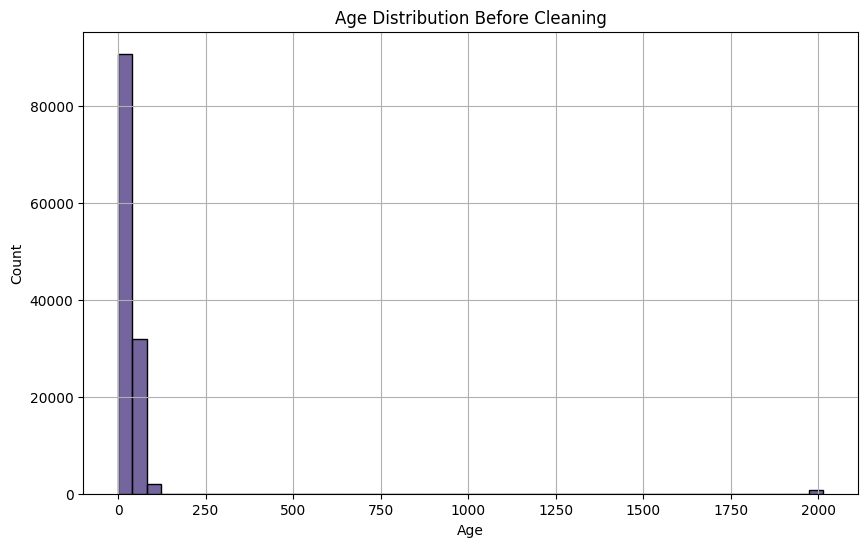

Age range before cleaning: 1.0 - 2014.0
Number of users with age < 14: 57
Number of users with age > 100: 2345


C:\Users\Family\AppData\Local\Temp\ipykernel_9036\1811425892.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_clean['age'].fillna(age_median, inplace=True)
C:\Users\Family\AppData\Local\Temp\ipykernel_9036\1811425892.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

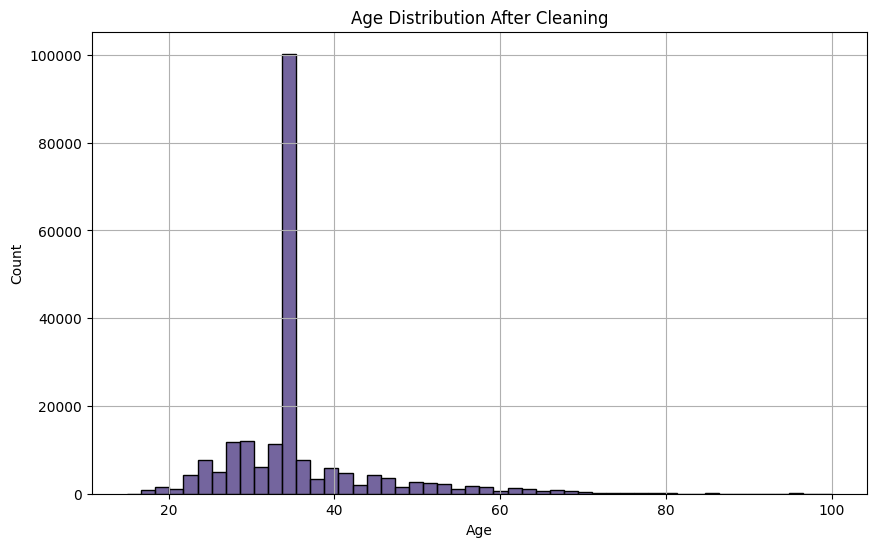

Age range after cleaning: 15.0 - 100.0


In [40]:
# Plot age distribution before cleaning
plt.figure(figsize=(10, 6))
sns.histplot(train_clean['age'].dropna(), bins=50)
plt.title('Age Distribution Before Cleaning')
plt.xlabel('Age')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# Identify age outliers
print(f"Age range before cleaning: {train_clean['age'].min()} - {train_clean['age'].max()}")
print(f"Number of users with age < 14: {(train_clean['age'] < 14).sum()}")
print(f"Number of users with age > 100: {(train_clean['age'] > 100).sum()}")

# Replace outliers with NaN
train_clean.loc[(train_clean['age'] < 14) | (train_clean['age'] > 100), 'age'] = np.nan
test_clean.loc[(test_clean['age'] < 14) | (test_clean['age'] > 100), 'age'] = np.nan

# Impute missing age values with median
age_median = train_clean['age'].median()
train_clean['age'].fillna(age_median, inplace=True)
test_clean['age'].fillna(age_median, inplace=True)

# Plot age distribution after cleaning
plt.figure(figsize=(10, 6))
sns.histplot(train_clean['age'], bins=50)
plt.title('Age Distribution After Cleaning')
plt.xlabel('Age')
plt.ylabel('Count')
plt.grid(True)
plt.show()

print(f"Age range after cleaning: {train_clean['age'].min()} - {train_clean['age'].max()}")

In [41]:
# Check gender distribution
print("Gender distribution before imputation:")
print(train_clean['gender'].value_counts(dropna=False))

# Fill missing gender with the most frequent value
most_common_gender = train_clean['gender'].mode()[0]
train_clean['gender'].fillna(most_common_gender, inplace=True)
test_clean['gender'].fillna(most_common_gender, inplace=True)

# Check gender distribution after imputation
print("\nGender distribution after imputation:")
print(train_clean['gender'].value_counts(dropna=False))

Gender distribution before imputation:
gender
-unknown-    95688
FEMALE       63041
MALE         54440
OTHER          282
Name: count, dtype: int64

Gender distribution after imputation:
gender
-unknown-    95688
FEMALE       63041
MALE         54440
OTHER          282
Name: count, dtype: int64


C:\Users\Family\AppData\Local\Temp\ipykernel_9036\118860907.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_clean['gender'].fillna(most_common_gender, inplace=True)
C:\Users\Family\AppData\Local\Temp\ipykernel_9036\118860907.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co

### 1.3 Handle Other Missing Values

In [42]:
# For categorical variables: fill with the most frequent value
categorical_cols = ['first_browser', 'first_device_type', 'signup_method', 'signup_flow', 'language']

for col in categorical_cols:
    most_common_val = train_clean[col].mode()[0]
    train_clean[col].fillna(most_common_val, inplace=True)
    test_clean[col].fillna(most_common_val, inplace=True)

# Check if there are any remaining missing values
missing_after = train_clean.isnull().sum()
print("Remaining missing values in training data:")
print(missing_after[missing_after > 0])

Remaining missing values in training data:
date_first_booking         124543
first_affiliate_tracked      6065
dtype: int64


C:\Users\Family\AppData\Local\Temp\ipykernel_9036\2768004752.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_clean[col].fillna(most_common_val, inplace=True)
C:\Users\Family\AppData\Local\Temp\ipykernel_9036\2768004752.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

# Encode Catigorical Data 

In [43]:
# Identify categorical columns
categorical_columns = train_clean.select_dtypes(include=['object']).columns.tolist()   
categorical_columns = train_clean.drop(columns=['id', 'date_account_created', 'timestamp_first_active', 'country_destination']).columns.tolist()
numerical_columns = train_clean.select_dtypes(exclude=['object']).columns.tolist()  


In [44]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
# Convert all values in categorical columns to strings
# Convert all values in categorical columns to strings
train_clean[categorical_columns] = train_clean[categorical_columns].astype(str)
test_clean[categorical_columns] = test_clean[categorical_columns].astype(str)
train_clean['country_destination'] = train_clean['country_destination'].astype(str)

# Apply the encoder
train_clean[categorical_columns] = encoder.fit_transform(train_clean[categorical_columns])
test_clean[categorical_columns] = encoder.transform(test_clean[categorical_columns])
train_clean['country_destination'] = encoder.fit_transform(train_clean['country_destination'].values.reshape(-1, 1))

## 6. Numerical Feature Scaling

In [45]:
# Identify numerical columns to scale (excluding IDs and dates and the target column)
numerical_cols = ['age', 'total_sessions', 'total_secs_elapsed', 'avg_secs_elapsed',
               'action_diversity', 'action_type_diversity', 'device_diversity',
               'days_between_first_active_and_account_created']

# Check if all the numerical columns exist in the DataFrames
numerical_cols = [col for col in numerical_cols if col in train_clean.columns]

# Create a scaler
scaler = StandardScaler()

# Fit and transform the training data
train_clean[numerical_cols] = scaler.fit_transform(train_clean[numerical_cols])

# Transform the test data
train_clean[numerical_cols] = scaler.transform(train_clean[numerical_cols])

# Check the scaled columns
print("Numerical columns after scaling:")
train_clean[numerical_cols].describe().T

Numerical columns after scaling:


,count,mean,std,min,25%,50%,75%,max
age,213451.00,-2.40,0.11,-2.67,-2.44,-2.42,-2.41,-1.61


# Feature Engineering

In [46]:
# Convert date_account_created to datetime
train_clean['date_account_created'] = pd.to_datetime(train_clean['date_account_created'])
test_clean['date_account_created'] = pd.to_datetime(test_clean['date_account_created'])

# Convert timestamp_first_active to datetime
train_clean['timestamp_first_active'] = pd.to_datetime(train_clean['timestamp_first_active'].astype(str), format='%Y%m%d%H%M%S')
test_clean['timestamp_first_active'] = pd.to_datetime(test_clean['timestamp_first_active'].astype(str), format='%Y%m%d%H%M%S')

# Extract date components from date_account_created
for df in [train_clean, test_clean]:
    # Year, month, day
    df['dac_year'] = df['date_account_created'].dt.year
    df['dac_month'] = df['date_account_created'].dt.month
    df['dac_day'] = df['date_account_created'].dt.day
    df['dac_dayofweek'] = df['date_account_created'].dt.dayofweek
    # Is weekend?
    df['dac_is_weekend'] = df['dac_dayofweek'].isin([5, 6]).astype(int)
    # Quarter
    df['dac_quarter'] = df['date_account_created'].dt.quarter

    # Extract time components from timestamp_first_active
    df['tfa_year'] = df['timestamp_first_active'].dt.year
    df['tfa_month'] = df['timestamp_first_active'].dt.month
    df['tfa_day'] = df['timestamp_first_active'].dt.day
    df['tfa_hour'] = df['timestamp_first_active'].dt.hour
    df['tfa_dayofweek'] = df['timestamp_first_active'].dt.dayofweek
    df['tfa_is_weekend'] = df['tfa_dayofweek'].isin([5, 6]).astype(int)
    df['tfa_quarter'] = df['timestamp_first_active'].dt.quarter

    # Create features for time between first active and account creation
    df['days_between_first_active_and_account_created'] = (df['date_account_created'] - df['timestamp_first_active']).dt.total_seconds() / (60 * 60 * 24)

# Check new date features
date_cols = [col for col in train_clean.columns if col.startswith('dac_') or col.startswith('tfa_') or col == 'days_between_first_active_and_account_created']
train_clean[date_cols].head()

,dac_year,dac_month,dac_day,dac_dayofweek,dac_is_weekend,dac_quarter,tfa_year,tfa_month,tfa_day,tfa_hour,tfa_dayofweek,tfa_is_weekend,tfa_quarter,days_between_first_active_and_account_created
0,2010,6,28,0,0,2,2009,3,19,4,3,0,1,465.81
1,2011,5,25,2,0,2,2009,5,23,17,5,1,2,731.26
2,2010,9,28,1,0,3,2009,6,9,23,1,0,2,475.03
3,2011,12,5,0,0,4,2009,10,31,6,5,1,4,764.75
4,2010,9,14,1,0,3,2009,12,8,6,1,0,4,279.74


# stratified cross-validation

In [47]:

# Define the number of splits for cross-validation
n_splits = 5

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Extract features (X) and target (y) from the training data
X = train_clean.drop(columns=['country_destination', 'id'])  # Drop target and ID columns
y = train_clean['country_destination']  # Target column

# Perform stratified splitting
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    print(f"Training set size: {X_train.shape[0]}, Validation set size: {X_val.shape[0]}")
    # You can now use X_train, X_val, y_train, y_val for training and validation or for testing

Fold 1
Training set size: 170760, Validation set size: 42691
Fold 2
Training set size: 170761, Validation set size: 42690
Fold 3
Training set size: 170761, Validation set size: 42690
Fold 4
Training set size: 170761, Validation set size: 42690
Fold 5
Training set size: 170761, Validation set size: 42690


In [48]:

# Convert datetime columns to numerical features
for col in ['date_account_created', 'timestamp_first_active']:
    X_train[col] = X_train[col].astype('int64') // 10**9  # Convert to seconds since epoch
    X_val[col] = X_val[col].astype('int64') // 10**9      # Convert to seconds since epoch

# Define and train the model
model = xgb.XGBClassifier(colsample_bytree=0.9, eval_metric='mlogloss', learning_rate=0.06, 
                 max_depth=7, n_estimators=120, n_jobs=-1, objective='multi:softproba', random_state=0)

model.fit(X_train, y_train)

C:\Users\Family\AppData\Local\Temp\ipykernel_9036\1680632336.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype('int64') // 10**9  # Convert to seconds since epoch
C:\Users\Family\AppData\Local\Temp\ipykernel_9036\1680632336.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[col] = X_val[col].astype('int64') // 10**9      # Convert to seconds since epoch
C:\Users\Family\AppData\Local\Temp\ipykernel_9036\1680632336.py:3: SettingWithCopyWarning: 
A value is trying to

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.06, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=120,
              n_jobs=-1, num_parallel_tree=None, objective='multi:softprob', ...)

In [49]:
# Predict probabilities for validation set
y_val_pred_proba = model.predict_proba(X_val)

# Convert y_val to one-hot encoding for NDCG calculation
y_val_one_hot = np.zeros((len(y_val), len(y.unique())))
for i, label in enumerate(y_val):
    y_val_one_hot[i, int(label)] = 1

# Calculate NDCG score
ndcg = ndcg_score(y_val_one_hot, y_val_pred_proba)
print(f"NDCG Score: {ndcg:.4f}")

NDCG Score: 0.9363


# Fainal score is 0.9363